# Analyze Weights&Bias Hyperparameter Search Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from scipy.stats import kruskal

from scikit_posthocs import posthoc_dunn

In [49]:
change_runs = {
    "node_type": {
        "pretrained_model": {
            "Binding_DDG": "residue",
            "DeepRefine": "atom"
        }
    },
    "learning_rate": {
        "batch_size": "divide"
    },
    "batch_size": {
        "node_type": {
            "atom": ("divide", 5)
        }
    },    
    "max_num_nodes": {
        "node_type": {
            "atom": ("multiply", 5)
        }
    }
    
}

remove_runs = {
    "attention_heads": {
        "layer_type": "GCN",
        "num_gnn_layers": 0
    },
    "gnn_type": {
        "num_gnn_layers": 0
    },
    "channel_halving": {
        "num_gnn_layers": 0
    },
    "channel_doubling": {
        "num_gnn_layers": 0
    },
    
}

def change_value(row: pd.Series, original_col: str, adaption_dict: Dict):
    for key, adaptions in adaption_dict.items():
        if isinstance(adaptions, str):
            if adaptions == "divide":
                row[original_col] / row[key]
        elif isinstance(adaptions, Dict) and key in row and row[key] in adaptions:
            if isinstance(adaptions[row[key]], str):
                return adaptions[row[key]]
            elif isinstance(adaptions[row[key]], Tuple):
                if adaptions[row[key]][0] == "divide":
                    row[original_col] / adaptions[row[key]][1]
                elif adaptions[row[key]][0] == "multiply":
                    row[original_col] * adaptions[row[key]][1]
    
    return row[original_col]


def remove_rows(row: pd.Series, original_col: str, remove_dict: Dict):
    for key, value in remove_dict.items():
        if row[key] == value:
            return False

    return True


def select_df(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    if x_min is not None:
        df = df[df[target] >= x_min].copy()
    if x_max is not None:
        df = df[df[target] <= x_max].copy()
    
    for col, adaption in change_runs.items():
        if group != col:
            continue
        df[col] = df.apply(lambda row: change_value(row, col, adaption), axis=1)
    for col, remove in remove_runs.items():
        if group != col:
            continue
        df = df[df.apply(lambda row: remove_rows(row, col, remove), axis=1)].copy()
        
    df = df[["Name", target, group]]

    return df[["Name", target, group]]


def plot_box_plot(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None, axis = None):
    mapping = {
        target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]),
        group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1, copy=True)
    
    if axis is not None:
        sns.boxplot(data=df, y=mapping[target], x=mapping[group], ax=axis)
    else:
        sns.boxplot(data=df, y=mapping[target], x=mapping[group])
        plt.show()


def calc_kruskal_wallis_score(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    mapping = {
            target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]),
            group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1)

    group_values = []
    results = []

    groups = df.groupby(mapping[group]).groups

    for value, idx in groups.items():
        group_values.append(value)
        results.append(df.loc[idx, mapping[target]])

    kruskal_results = kruskal(*results)
    print(f"Kruskal results for parameter {mapping[group]}: H={kruskal_results[0]}, p_value={kruskal_results[1]}  ")

    if kruskal_results[1] < 0.05:
        # perform posthoc analyis
        posthoc_results = posthoc_dunn(df, val_col=mapping[target], group_col=mapping[group])
        print("\tResults of Posthoc analysis with Bonferri correction")
        print(posthoc_results < 0.05)
        
    return kruskal_results, group_values

In [43]:
TARGET_VALUE = "abag_affinity:absolute_val_rmse"

## Exploratory Hyperparameter Search

In [44]:
exploratory_filepath = "/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/results/exploratory_gnn_hyperparameter_search_results.csv"
exploratory_df = pd.read_csv(exploratory_filepath)
exploratory_df.head()

,Name,Runtime,abag_affinity:absolute_val_corr,abag_affinity:absolute_val_loss,abag_affinity:absolute_val_rmse,aggregation_method,attention_heads,batch_size,channel_halving,max_num_nodes,node_type,loss_function,layer_type,gnn_type,num_gnn_layers,num_fc_layers,fc_size_halving,nonlinearity,relaxed_pdbs,learning_rate
0,playful-sweep-81,2053,0.545581,0.053774,1.188739,mean,5,1,True,None,residue,L1,GCN,guided,5,10,False,leaky,True,0.000237
1,honest-sweep-48,2300,0.502374,0.004965,1.197917,mean,5,1,True,None,residue,L2,GCN,guided,0,10,False,gelu,False,0.000266
2,resilient-sweep-142,1490,0.453996,0.055301,1.230724,mean,1,1,True,50,residue,L1,GAT,guided,5,5,True,relu,True,0.000733
3,scarlet-sweep-177,1168,0.434192,0.932631,1.247888,mean,5,1,True,None,residue,L1,GAT,guided,5,1,True,relu,False,0.000152
4,helpful-sweep-64,1070,0.415404,1.567881,1.252151,attention,5,1,False,None,residue,L2,GCN,guided,0,10,False,leaky,False,0.000217


In [45]:
non_categorical_hyperparameters = ["learning_rate"]
hyperparameters = [col for col in exploratory_df.columns if ":" not in col and col not in ["Name", "Runtime"] + non_categorical_hyperparameters]
hyperparameters

['aggregation_method',
 'attention_heads',
 'batch_size',
 'channel_halving',
 'max_num_nodes',
 'node_type',
 'loss_function',
 'layer_type',
 'gnn_type',
 'num_gnn_layers',
 'num_fc_layers',
 'fc_size_halving',
 'nonlinearity',
 'relaxed_pdbs']

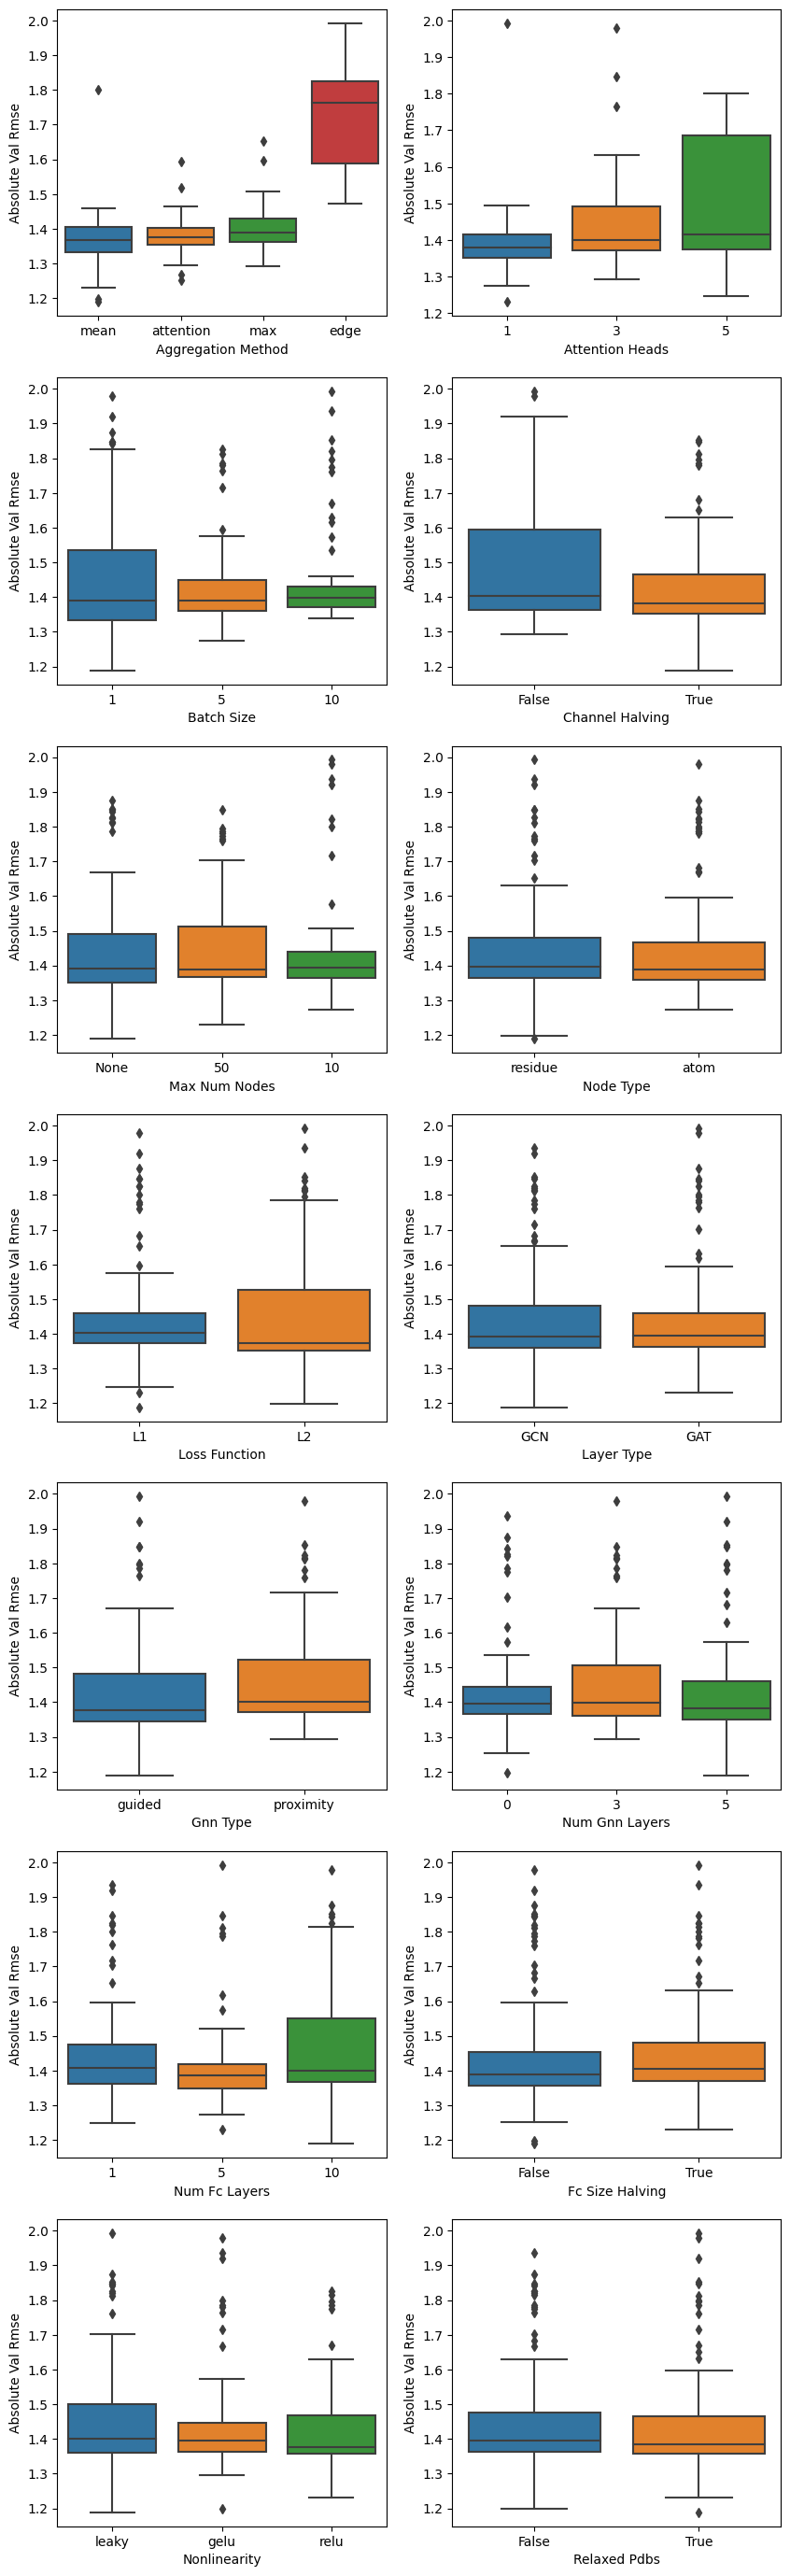

In [46]:
cols = 2
rows = int(len(hyperparameters) / cols)

fig, axs = plt.subplots(figsize=(10,rows * 5), nrows=rows, ncols=cols)

for i, parameter in enumerate(hyperparameters):
    ii = int(i / cols)
    jj = i % 2
    plot_box_plot(exploratory_df, TARGET_VALUE, parameter, x_min=None, x_max=2, axis=axs[ii, jj])
plt.show()

In [54]:
rows = []

for i, parameter in enumerate(hyperparameters):
    (h, p), parameter_values = calc_kruskal_wallis_score(exploratory_df, TARGET_VALUE, parameter, x_min=None, x_max=10000)
    rows.append({
        "Hyperparameter": parameter,
        "Values": parameter_values,
        "Kruskal H-score": h,
        "Kruskal p_value": p,
        "significant_difference": p < 0.05
    })
    print()
    
parameter_comparison_df = pd.DataFrame(rows)

Kruskal results for parameter Aggregation Method: H=110.41862530649337, p_value=8.917486702690599e-24  
	Results of Posthoc analysis with Bonferri correction
           attention   edge    max   mean
attention      False   True  False  False
edge            True  False   True   True
max            False   True  False   True
mean           False   True   True  False

Kruskal results for parameter Attention Heads: H=5.7417334694661974, p_value=0.05664980494164086  

Kruskal results for parameter Batch Size: H=0.7823006009490427, p_value=0.6762785034202894  

Kruskal results for parameter Channel Halving: H=1.219512195121922, p_value=0.26945640515977975  

Kruskal results for parameter Max Num Nodes: H=0.3508024370248677, p_value=0.8391202826293872  

Kruskal results for parameter Node Type: H=0.005225530501320463, p_value=0.9423728488672416  

Kruskal results for parameter Loss Function: H=4.616021465853123, p_value=0.03167462490776723  
	Results of Posthoc analysis with Bonferri correct

In [55]:
parameter_comparison_df.to_latex()

,Hyperparameter,Values,Kruskal H-score,Kruskal p_value,significant_difference
0,aggregation_method,"[attention, edge, max, mean]",110.418625,8.917487e-24,True
1,attention_heads,"[1, 3, 5]",5.741733,5.664980e-02,False
2,batch_size,"[1, 5, 10]",0.782301,6.762785e-01,False
3,channel_halving,"[False, True]",1.219512,2.694564e-01,False
4,max_num_nodes,"[10, 50, None]",0.350802,8.391203e-01,False
5,node_type,"[atom, residue]",0.005226,9.423728e-01,False
6,loss_function,"[L1, L2]",4.616021,3.167462e-02,True
7,layer_type,"[GAT, GCN]",0.016007,8.993218e-01,False
8,gnn_type,"[guided, proximity]",2.598949,1.069346e-01,False
9,num_gnn_layers,"[0, 3, 5]",4.472805,1.068422e-01,False


In [56]:
parameter_comparison_df.to_latex()

'\\begin{tabular}{lllrrl}\n\\toprule\n{} &      Hyperparameter &                        Values &  Kruskal H-score &  Kruskal p\\_value &  significant\\_difference \\\\\n\\midrule\n0  &  aggregation\\_method &  [attention, edge, max, mean] &       110.418625 &     8.917487e-24 &                    True \\\\\n1  &     attention\\_heads &                     [1, 3, 5] &         5.741733 &     5.664980e-02 &                   False \\\\\n2  &          batch\\_size &                    [1, 5, 10] &         0.782301 &     6.762785e-01 &                   False \\\\\n3  &     channel\\_halving &                 [False, True] &         1.219512 &     2.694564e-01 &                   False \\\\\n4  &       max\\_num\\_nodes &                [10, 50, None] &         0.350802 &     8.391203e-01 &                   False \\\\\n5  &           node\\_type &               [atom, residue] &         0.005226 &     9.423728e-01 &                   False \\\\\n6  &       loss\\_function &                